In [7]:
#!/usr/bin/env python3
import gym
from collections import namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd


HIDDEN_SIZE = 128   # Kích thước của hidden layer trong mạng nơ-ron
BATCH_SIZE = 16     # Kích thước của mỗi batch (số lượng trạng thái trong mỗi batch)
PERCENTILE = 70     # Phần trăm percentile (dùng để chọn ra các trạng thái tốt nhất)
MAX_EPISODES = 200  # Số lượng episodes tối đa

In [2]:
class Net(nn.Module):
    '''
    Mạng nơ-ron đơn giản với 1 lớp ẩn và 1 lớp đầu ra
    '''
    def __init__(self, obs_size: int, hidden_size: int, n_actions: int):
        super(Net, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size), # Lớp đầu vào có obs_size đầu vào và hidden_size đầu ra
            nn.ReLU(),                        # Lớp kích hoạt ReLU 
            nn.Linear(hidden_size, n_actions) # Lớp đầu ra có hidden_size đầu vào và n_actions đầu ra
        )

    def forward(self, x):
        '''
        Hàm forward tính toán đầu ra của mạng nơ-ron
        '''
        return self.net(x)

In [3]:
# Khởi tạo tuples để lưu trữ episode và bước
from gym import Env


Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

def iterate_batches(env: Env, net: Net, batch_size: int):
    '''
    Dùng để tạo ra các batch từ môi trường và mạng neural network,
    mỗi batch chứa một số episode và mỗi episode chứa một số bước
    - env: môi trường
    - net: mạng neural network
    - batch_size: số episode trong một batch
    '''

    # Khởi tạo một list để chứa các episode
    batch = []
    # Khởi tạo reward của một episode
    episode_reward = 0.0
    # Khởi tạo list để chứa các bước trong một episode
    episode_steps = []
    # Khởi tạo môi trường
    obs, _ = env.reset()
    # Khởi tạo softmax layer
    Softmax = nn.Softmax(dim=1)

    # Lặp qua các episode
    while True:
        # Chuyển observation về dạng tensor
        obs_v = torch.FloatTensor([obs])
        # Tính toán output từ mạng neural network
        act_probs_v = Softmax(net(obs_v))
        # Chuyển output về dạng numpy
        act_probs = act_probs_v.data.numpy()[0]

        # Chọn action dựa trên output một cách ngẫu nhiên
        action = np.random.choice(len(act_probs), p=act_probs)

        # Thực hiện action và nhận lại observation, reward, is_done
        next_obs, reward, is_done, _, _ = env.step(action)

        # Cộng dồn reward của episode
        episode_reward += reward

        # Tạo một bước trong episode và thêm vào list episode_steps
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)

        # Nếu episode kết thúc
        if is_done:
            # Tạo một episode mới và thêm vào list batch
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            # Reset các biến
            episode_reward = 0.0
            episode_steps = []
            next_obs, _ = env.reset()

            # Nếu list batch đủ lớn thì trả về list batch
            if len(batch) == batch_size:
                # Trả về list batch
                yield batch
                batch = []
        
        # Cập nhật observation
        obs = next_obs



In [4]:
def filter_batch(batch: list, percentile: int):
    # Tạo một list chứa các reward của các episode trong batch
    rewards = list(map(lambda s: s.reward, batch))
    # Tính reward_bound từ percentile của list trên
    reward_bound = np.percentile(rewards, percentile)
    # Tính reward_mean từ mean của list trên
    reward_mean = float(np.mean(rewards))

    # Tạo 2 list rỗng để chứa các observation và action
    train_obs = []
    train_act = []

    # Duyệt qua từng episode trong batch
    for reward, steps in batch:
        # Nếu reward của episode < reward_bound thì bỏ qua
        if reward < reward_bound:
            continue

        # Nếu không thì thêm observation và action của từng step trong episode vào 2 list trên
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean


C:\Users\tiennhm\AppData\Roaming\Python\Python310\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\tiennhm\AppData\Roaming\Python\Python310\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0: loss=0.666, reward_mean=19.9, rw_bound=25.0
1: loss=0.689, reward_mean=22.0, rw_bound=28.0
2: loss=0.668, reward_mean=19.1, rw_bound=23.5
3: loss=0.670, reward_mean=33.7, rw_bound=40.0
4: loss=0.662, reward_mean=23.8, rw_bound=29.5
5: loss=0.662, reward_mean=31.5, rw_bound=34.5
6: loss=0.649, reward_mean=35.6, rw_bound=42.0
7: loss=0.630, reward_mean=45.6, rw_bound=50.5
8: loss=0.612, reward_mean=59.2, rw_bound=68.0
9: loss=0.608, reward_mean=50.0, rw_bound=64.0
10: loss=0.615, reward_mean=55.6, rw_bound=62.5
11: loss=0.579, reward_mean=61.6, rw_bound=58.5
12: loss=0.605, reward_mean=65.3, rw_bound=75.0
13: loss=0.577, reward_mean=68.2, rw_bound=78.0
14: loss=0.569, reward_mean=62.9, rw_bound=71.5
15: loss=0.557, reward_mean=71.1, rw_bound=67.0
16: loss=0.574, reward_mean=74.9, rw_bound=83.0
17: loss=0.565, reward_mean=60.1, rw_bound=64.0
18: loss=0.544, reward_mean=79.2, rw_bound=86.0
19: loss=0.572, reward_mean=81.7, rw_bound=81.5
20: loss=0.550, reward_mean=90.2, rw_bound=91.0
21

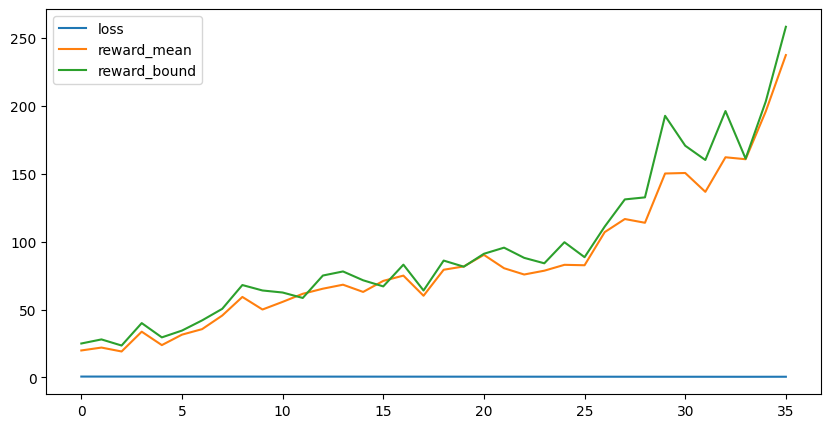

In [10]:
if __name__ == "__main__":
    # Khởi tạo môi trường CartPole-v0 của OpenAI Gym (tối đa 200 episodes)
    env = gym.make("CartPole-v0", render_mode="human")
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    # Khởi tạo mô hình
    net = Net(obs_size, HIDDEN_SIZE, n_actions)

    # Sử dụng Adam optimizer để tối ưu hóa mô hình
    optimizer = optim.Adam(params=net.parameters(), lr=0.01)

    # Sử dụng CrossEntropyLoss để tính loss
    CrossEntropyLoss = nn.CrossEntropyLoss()

    # Tạo DataFrames để vẽ biểu đồ, gồm các cột: episode, loss, reward_mean, reward_bound
    df = pd.DataFrame(columns=['episode', 'loss', 'reward_mean', 'reward_bound'], dtype=float, index=range(MAX_EPISODES))


    # Huấn luyện mô hình và tối ưu hóa
    for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
        # Lọc ra các batch có reward cao
        obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
        
        optimizer.zero_grad()
        action_scores_v = net(obs_v)

        # Tính loss bằng cách sử dụng CrossEntropyLoss
        loss_v = CrossEntropyLoss(action_scores_v, acts_v)

        loss_v.backward()
        optimizer.step()

        print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (iter_no, loss_v.item(), reward_m, reward_b))
        # Thêm dữ liệu vào DataFrame
        data_record = {'episode': iter_no, 'loss': loss_v.item(), 'reward_mean': reward_m, 'reward_bound': reward_b}
        df.loc[iter_no] = data_record

        # Kiểm tra xem mô hình đã giải quyết bài toán chưa
        if reward_m >= MAX_EPISODES:
            print("Solved!")
            break


# Vẽ biểu đồ loss, reward_mean, reward_bound theo episode
plt.figure(figsize=(10, 5))
plt.plot(df['episode'], df['loss'], label='loss')
plt.plot(df['episode'], df['reward_mean'], label='reward_mean')
plt.plot(df['episode'], df['reward_bound'], label='reward_bound')
plt.legend()
plt.show()
